In [40]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

# 5 pieces of data -> 3 pieces of data
#Source: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/12_quantum_autoencoder.html

In [41]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)


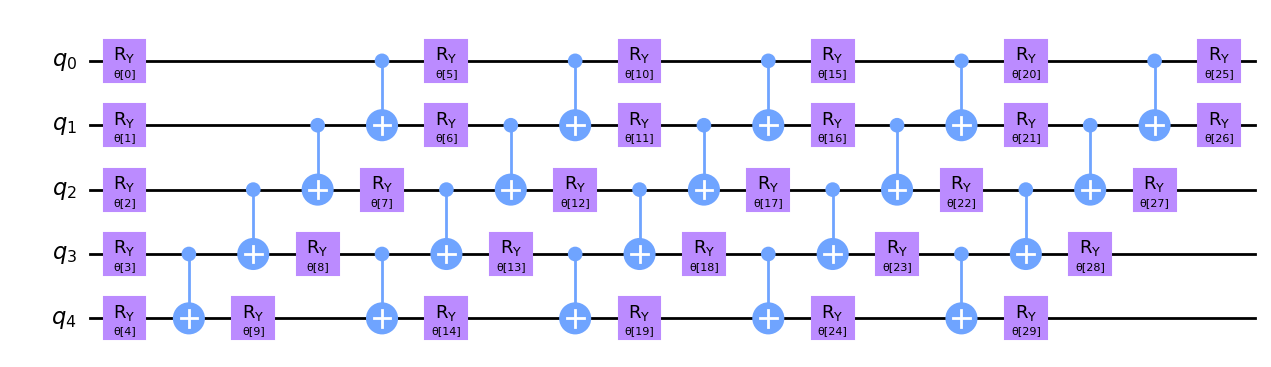

In [42]:
num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw(output="mpl", style="clifford")

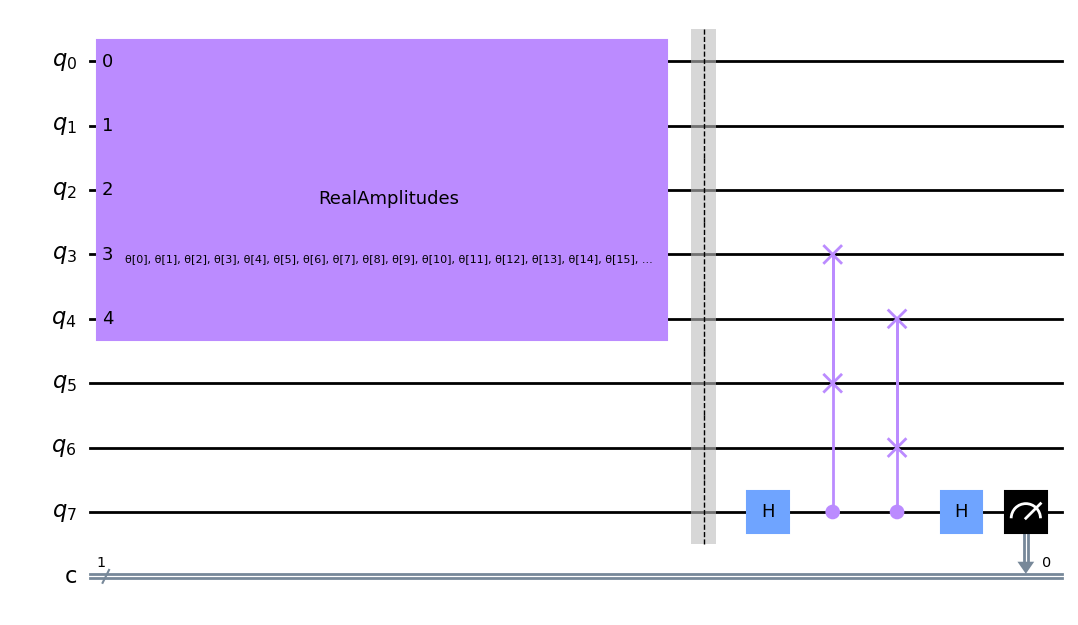

In [43]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    #circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.compose(ansatz(num_latent + num_trash), {0,1,2,3,4}, inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")

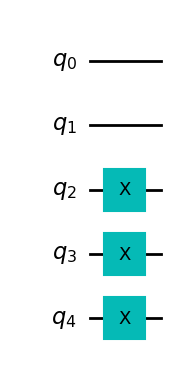

In [44]:
def domain_wall(circuit, a, b):
    # Here we place the Domain Wall to qubits a - b in our circuit
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit


domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl", style="clifford")

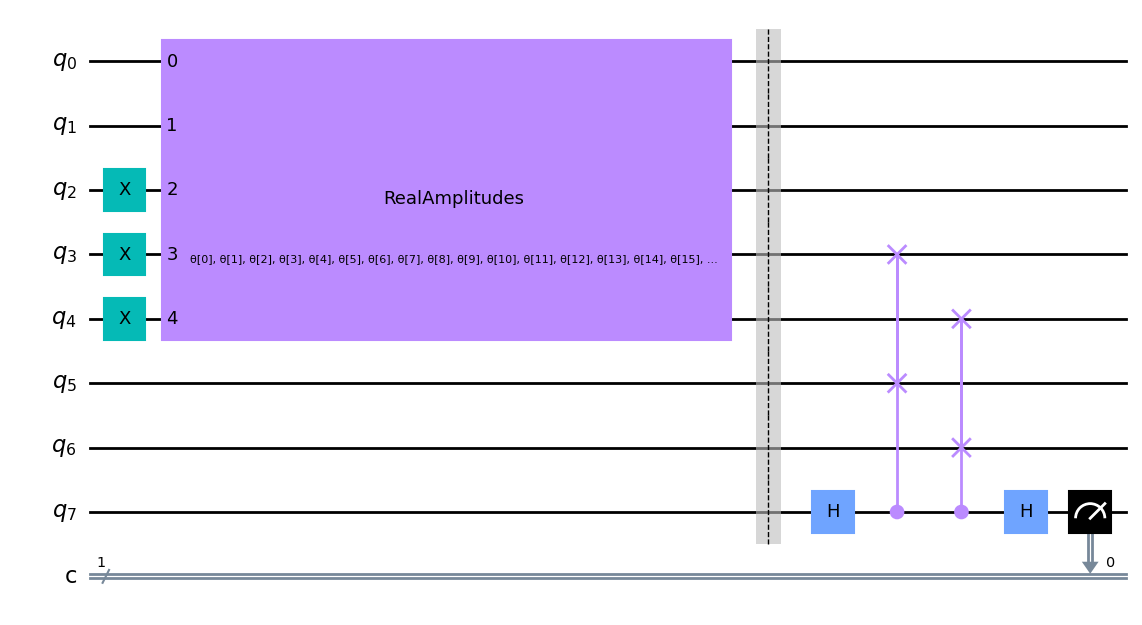

In [45]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw(output="mpl", style="clifford")

In [46]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [47]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

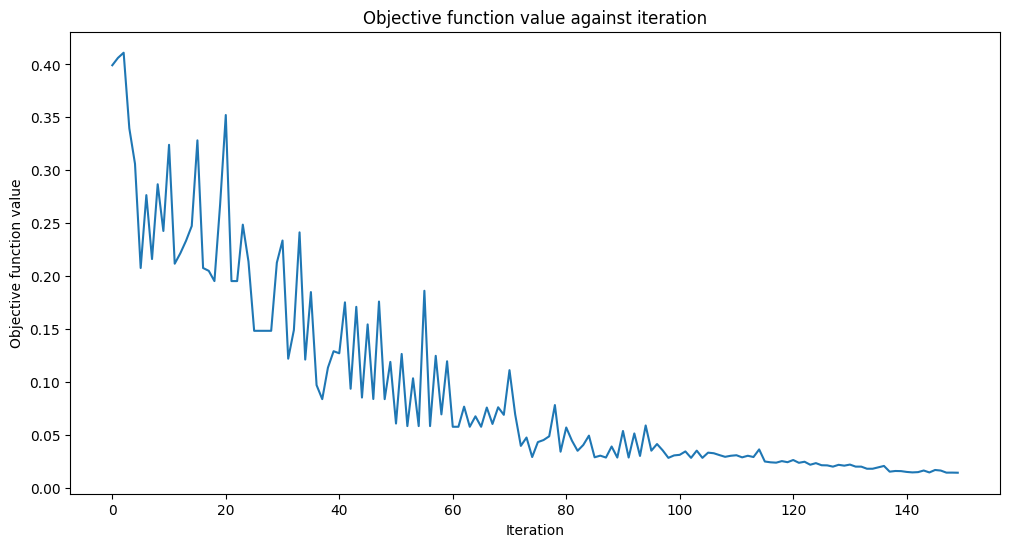

Fit in 23.68 seconds


In [48]:
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

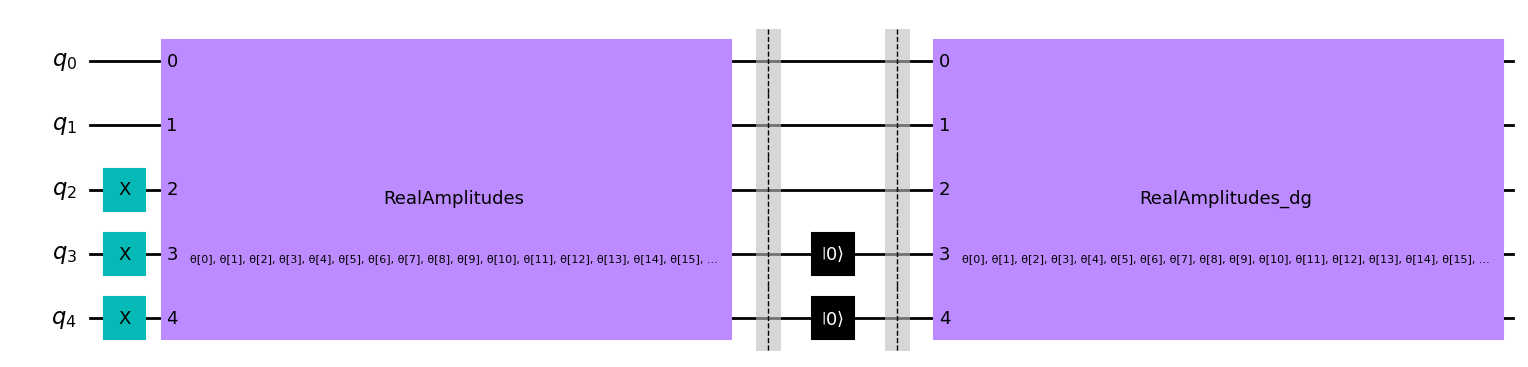

In [49]:
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(domain_wall_circuit)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw(output="mpl", style="clifford")

In [50]:
test_qc = test_qc.assign_parameters(opt_result.x)

In [51]:
domain_wall_state = Statevector(domain_wall_circuit).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(domain_wall_state.conj(), output_state) ** 2)
print("Fidelity of our Output State with our Input State: ", fidelity.real)

Fidelity of our Output State with our Input State:  0.9854280347279166
